In [10]:
import sys
sys.path.insert(1, '../../libs')
from utils import get_data, temporal_train_test_split
from autorship import AuthorClassifier
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import TweetTokenizer
from imblearn.under_sampling import RandomUnderSampler
from joblib import Parallel, delayed
from scipy.stats import ttest_ind, pearsonr
from statsmodels.graphics.gofplots import qqplot
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from joblib import Parallel, delayed

In [2]:
data = get_data("../../data/authors.csv")

/home/vinicius/.local/share/virtualenvs/reddit-in-portuguese-Kyc7Ejcc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='comment'>

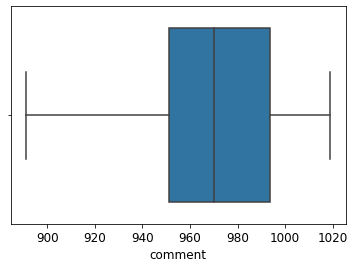

In [27]:
sns.boxplot(data.groupby("username")["comment"].count())

<AxesSubplot:xlabel='comment', ylabel='Density'>

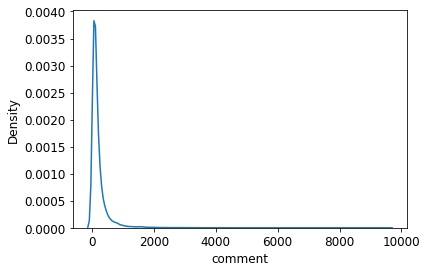

In [28]:
sns.kdeplot(data[data.comment.str.len() >= 25].comment.str.len())

<AxesSubplot:xlabel='comment', ylabel='Density'>

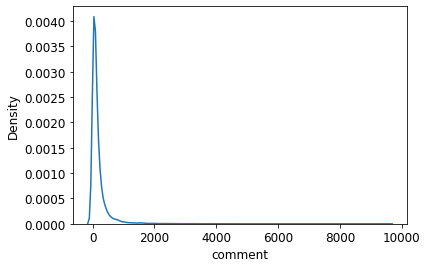

In [29]:
sns.kdeplot(data.comment.str.len())

In [6]:
data = data[data.comment.str.len() >= 25]

In [7]:
data.groupby("username")["comment"].count()

username
9-Cortes            966
AgnaldoTeExplode    828
BeatoSalut          832
BluePirate89        707
CariocaSatanico     969
Manada_2            851
MaxVonHabsburg      899
MidnightRider00     983
Miteiro             765
Supermunch2000      863
TheGza1             753
logatwork           803
piperman_           751
um--no              950
xanax101010         799
Name: comment, dtype: int64

/home/vinicius/.local/share/virtualenvs/reddit-in-portuguese-Kyc7Ejcc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='comment'>

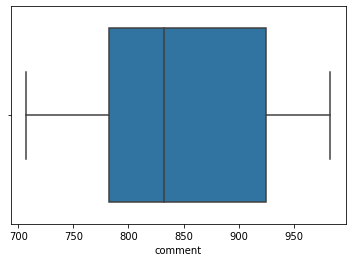

In [7]:
sns.boxplot(data.groupby("username")["comment"].count())

In [7]:
tt = TweetTokenizer()

estimators = [
        ('svm', LinearSVC(random_state=42, max_iter=10000)),
        ('lr_l1', LogisticRegression(random_state=42, penalty="l1", solver="liblinear"),
        ('rf'), RandomForestClassifier(random_state=42))]
stacking = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(random_state=42, penalty="l2", solver="liblinear"))

grid = [(MultinomialNB(), CountVectorizer(ngram_range=(1,3), analyzer="word", tokenizer=tt.tokenize)),
        (LogisticRegression(random_state=42, penalty="l1", solver="liblinear"), TfidfVectorizer(ngram_range=(1,5), analyzer="char")),
        (LogisticRegression(random_state=42, penalty="l2", solver="liblinear"), TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (LinearSVC(random_state=42, max_iter=10000), TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (SVC(random_state=42), TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (DecisionTreeClassifier(random_state=42), CountVectorizer(ngram_range=(1,3), analyzer="word", tokenizer=tt.tokenize)),
        (RandomForestClassifier(random_state=42), CountVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize)),
        (AdaBoostClassifier(random_state=42), CountVectorizer(ngram_range=(1,5), analyzer="char")),
        (GradientBoostingClassifier(random_state=42), CountVectorizer(ngram_range=(1,3), analyzer="char")),
        (stacking, TfidfVectorizer(ngram_range=(1,1), analyzer="word", tokenizer=tt.tokenize))
        ]

In [9]:
from joblib import Parallel, delayed
def process(clf, vectorizer):
    clf_str = clf.__str__()
    print(f"Running ===> {clf_str}")
    evaluation = list()
    usernames = list(np.unique(data["username"]))

    for i in range(len(usernames)):
        author1 = usernames.pop()

        for author2 in usernames:
            X_train, X_test, y_train, y_test = temporal_train_test_split(   
                data, author1, author2)

            author_clf = AuthorClassifier(clf=clf, vectorizer=vectorizer, scaler=MaxAbsScaler())
            author_clf.fit(X_train["comment"], y_train)
            y_pred = author_clf.predict(X_test["comment"])
            evaluation.append(author_clf.evaluate(y_test, y_pred))

    metrics = pd.DataFrame(evaluation)
    metrics["clf"] = [clf_str for i in range(len(metrics))]

    print(f"Finish <=== {clf_str}")
    return metrics
        
results = Parallel(n_jobs=7)(delayed(process)(clf, vectorizer) for clf, vectorizer in grid)

Running ===> LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
Running ===> MultinomialNB()
Running ===> LinearSVC(max_iter=10000, random_state=42)
Running ===> LogisticRegression(random_state=42, solver='liblinear')
Running ===> DecisionTreeClassifier(random_state=42)
Running ===> RandomForestClassifier(random_state=42)
Running ===> SVC(random_state=42)
Finish <=== LinearSVC(max_iter=10000, random_state=42)
Running ===> AdaBoostClassifier(random_state=42)
Finish <=== LogisticRegression(random_state=42, solver='liblinear')
Running ===> GradientBoostingClassifier(random_state=42)
Finish <=== MultinomialNB()
Running ===> StackingClassifier(estimators=[('svm',
                                LinearSVC(max_iter=10000, random_state=42)),
                               ('lr_l1',
                                LogisticRegression(penalty='l1',
                                                   random_state=42,
                                                   solver='libl

/home/vinicius/.local/share/virtualenvs/reddit-in-portuguese-Kyc7Ejcc/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/vinicius/.local/share/virtualenvs/reddit-in-portuguese-Kyc7Ejcc/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finish <=== StackingClassifier(estimators=[('svm',
                                LinearSVC(max_iter=10000, random_state=42)),
                               ('lr_l1',
                                LogisticRegression(penalty='l1',
                                                   random_state=42,
                                                   solver='liblinear'),
                                'rf',
                                RandomForestClassifier(random_state=42))],
                   final_estimator=LogisticRegression(random_state=42,
                                                      solver='liblinear'))
Finish <=== DecisionTreeClassifier(random_state=42)
Finish <=== LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
Finish <=== GradientBoostingClassifier(random_state=42)
Finish <=== AdaBoostClassifier(random_state=42)


In [10]:
metrics_df = pd.concat(results)
metrics_df.sample(10)

,author1,author2,precision_author1,recall_author1,f1_score_author1,precision_author2,recall_author2,f1_score_author2,precision_weighted,precision_micro,precision_macro,recall_weighted,recall_micro,recall_macro,f1_weighted,f1_micro,f1_macro,auc_score,accuracy,clf
37,TheGza1,piperman_,0.9524,0.7407,0.8333,0.7870,0.9628,0.8660,0.8699,0.8515,0.8697,0.8515,0.8515,0.8518,0.8496,0.8515,0.8497,0.9345,0.8515,SVC(random_state=42)
75,MaxVonHabsburg,Miteiro,0.9221,0.9467,0.9342,0.9355,0.9062,0.9206,0.9283,0.9281,0.9288,0.9281,0.9281,0.9265,0.9280,0.9281,0.9274,0.9800,0.9281,"LinearSVC(max_iter=10000, random_state=42)"
3,BluePirate89,xanax101010,0.8351,0.4576,0.5912,0.6571,0.9200,0.7667,0.7407,0.7029,0.7461,0.7029,0.7029,0.6888,0.6843,0.7029,0.6790,0.7814,0.7029,SVC(random_state=42)
80,BluePirate89,MidnightRider00,0.9217,0.8644,0.8921,0.9066,0.9472,0.9264,0.9129,0.9125,0.9142,0.9125,0.9125,0.9058,0.9121,0.9125,0.9093,0.9735,0.9125,"StackingClassifier(estimators=[('svm',\n ..."
26,piperman_,um--no,0.7487,0.7606,0.7546,0.8085,0.7983,0.8034,0.7821,0.7817,0.7786,0.7817,0.7817,0.7795,0.7819,0.7817,0.7790,0.8779,0.7817,RandomForestClassifier(random_state=42)
51,AgnaldoTeExplode,TheGza1,0.9062,0.8406,0.8722,0.8382,0.9048,0.8702,0.8738,0.8712,0.8722,0.8712,0.8712,0.8727,0.8712,0.8712,0.8712,0.9232,0.8712,"LogisticRegression(penalty='l1', random_state=..."
39,9-Cortes,logatwork,0.8996,0.8884,0.8940,0.8676,0.8806,0.8741,0.8851,0.8849,0.8836,0.8849,0.8849,0.8845,0.8849,0.8849,0.8840,0.9528,0.8849,AdaBoostClassifier(random_state=42)
104,9-Cortes,AgnaldoTeExplode,0.8200,0.8471,0.8333,0.8141,0.7826,0.7980,0.8173,0.8174,0.8170,0.8174,0.8174,0.8149,0.8171,0.8174,0.8157,0.9109,0.8174,"LogisticRegression(penalty='l1', random_state=..."
67,MidnightRider00,Supermunch2000,0.7722,0.7439,0.7578,0.7200,0.7500,0.7347,0.7478,0.7468,0.7461,0.7468,0.7468,0.7470,0.7470,0.7468,0.7462,0.8420,0.7468,RandomForestClassifier(random_state=42)
29,BeatoSalut,piperman_,0.8366,0.8125,0.8244,0.7990,0.8245,0.8115,0.8188,0.8182,0.8178,0.8182,0.8182,0.8185,0.8183,0.8182,0.8180,0.9055,0.8182,AdaBoostClassifier(random_state=42)


In [12]:
metrics_df.clf.unique()

array(['MultinomialNB()',
       "LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",
       "LogisticRegression(random_state=42, solver='liblinear')",
       'LinearSVC(max_iter=10000, random_state=42)',
       'SVC(random_state=42)', 'DecisionTreeClassifier(random_state=42)',
       'RandomForestClassifier(random_state=42)',
       'AdaBoostClassifier(random_state=42)',
       'GradientBoostingClassifier(random_state=42)',
       "StackingClassifier(estimators=[('svm',\n                                LinearSVC(max_iter=10000, random_state=42)),\n                               ('lr_l1',\n                                LogisticRegression(penalty='l1',\n                                                   random_state=42,\n                                                   solver='liblinear'),\n                                'rf',\n                                RandomForestClassifier(random_state=42))],\n                   final_estimator=LogisticRegression(random

In [13]:
keys = metrics_df.clf.unique()
values = ['Naive Bayes Multinomial',
        'Regressão Logística (L1)',
        'Regressão Logística (L2)',
        'SVM (kernel linear)',
        'SVM (kernel rbf)',
        'Árvore de Decisão',
        'Random Forest',
        'AdaBoost',
        'Gradient boosting',
        'Stacking']

dict_clf = dict(zip(keys, values))

In [14]:
metrics_df["clf"] = metrics_df["clf"].map(dict_clf)

In [15]:
metrics_df.to_csv("../../results/otimal_results_min_size.csv")

In [16]:
keys = ['Naive Bayes Multinomial',
        'Regressão Logística (L1)',
        'Regressão Logística (L2)',
        'SVM (kernel linear)',
        'SVM (kernel rbf)',
        'Árvore de Decisão',
        'Random Forest',
        'AdaBoost',
        'Gradient boosting',
        'Stacking']

values = ['Multinomial Naive Bayes',
        'Logistic Regression (L1)',
        'Logistic Regression (L2)',
        'SVM (linear kernel)',
        'SVM (rbf kernel)',
        'Decision Tree',
        'Random Forest',
        'AdaBoost',
        'Gradient boosting',
        'Stacking']

dict_clf = dict(zip(keys, values))

In [17]:
metrics_df["clf"] = metrics_df["clf"].map(dict_clf)

Text(0, 0.5, 'Accuracy')

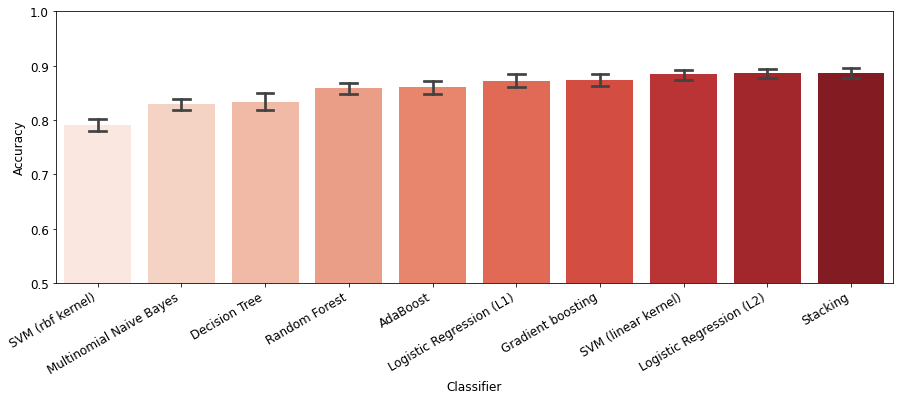

In [18]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='accuracy', data=metrics_df, estimator=np.mean, ci=95, capsize=.2,palette="Reds", order=metrics_df.groupby("clf").mean()["accuracy"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1-score')

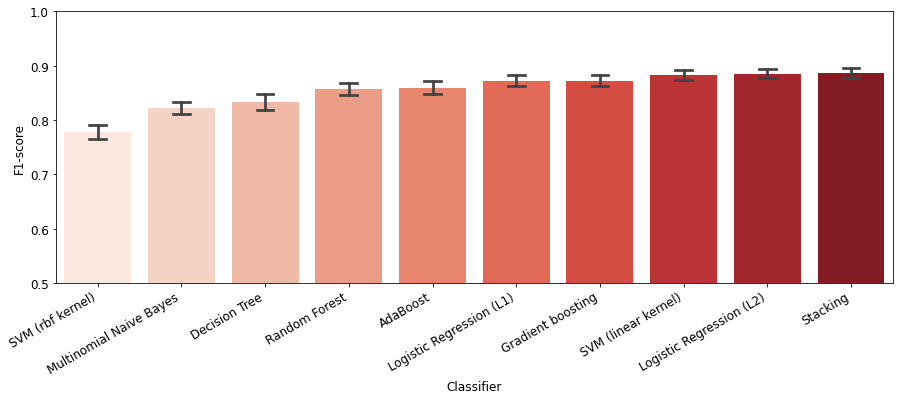

In [19]:
plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='f1_macro', data=metrics_df, estimator=np.mean, ci=95, capsize=.2,palette="Reds", order=metrics_df.groupby("clf").mean()["f1_macro"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('F1-score')

Text(0, 0.5, 'AUC')

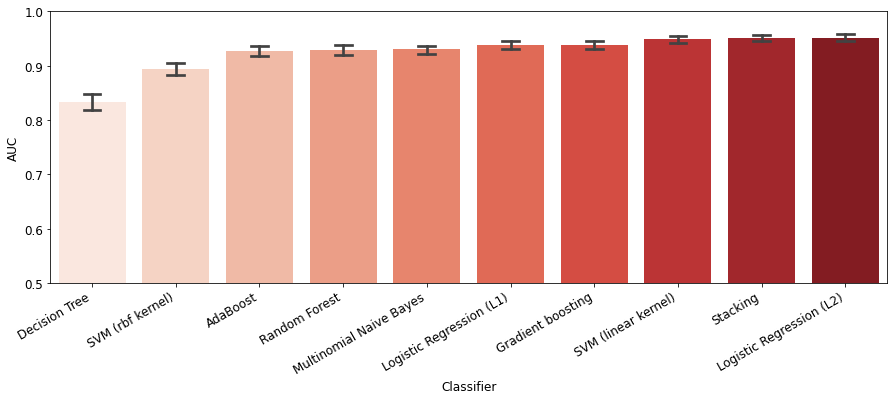

In [20]:
plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='auc_score', data=metrics_df, estimator=np.mean, ci=95, capsize=.2, palette="Reds", order=metrics_df.groupby("clf").mean()["auc_score"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('AUC')

Text(0, 0.5, 'Accuracy')

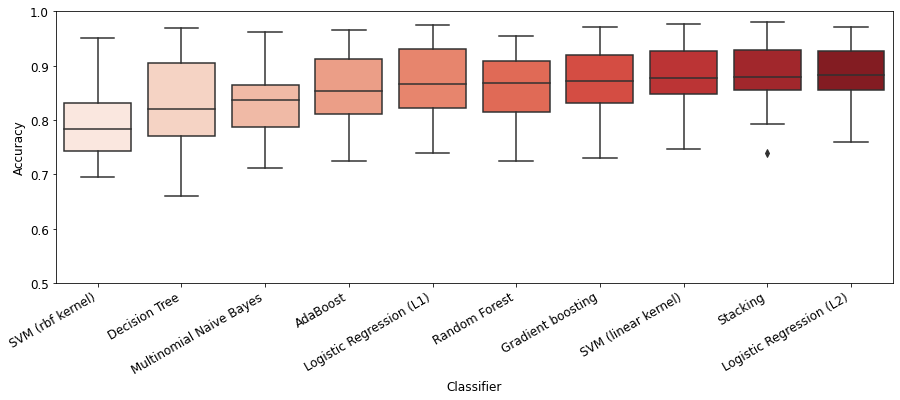

In [21]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.boxplot(x='clf', y='accuracy', data=metrics_df, palette="Reds", order=metrics_df.groupby("clf").median()["accuracy"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1-score')

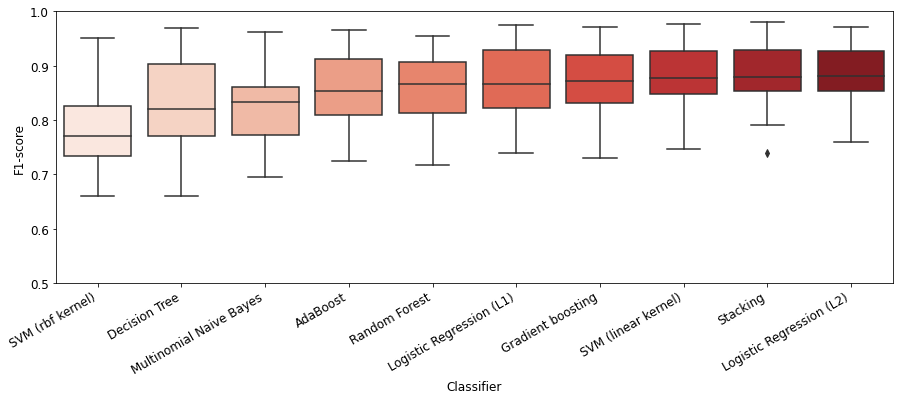

In [22]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.boxplot(x='clf', y='f1_macro', data=metrics_df, palette="Reds", order=metrics_df.groupby("clf").median()["f1_macro"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('F1-score')

Text(0, 0.5, 'AUC')

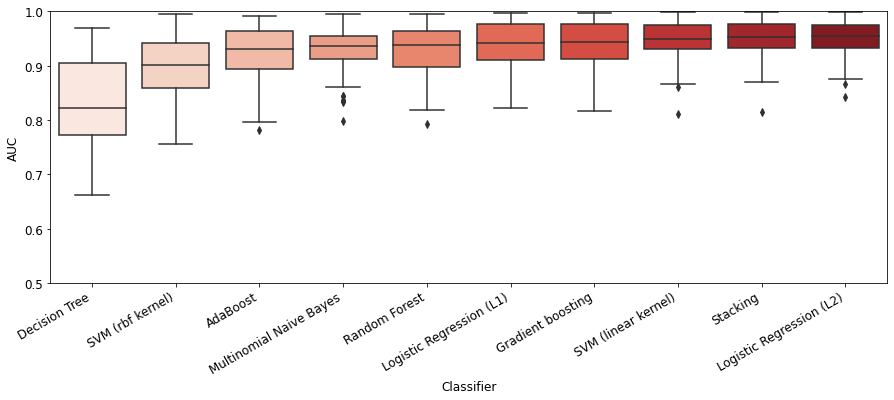

In [23]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.boxplot(x='clf', y='auc_score', data=metrics_df, palette="Reds", order=metrics_df.groupby("clf").median()["auc_score"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('AUC')

<AxesSubplot:xlabel='comment', ylabel='Density'>

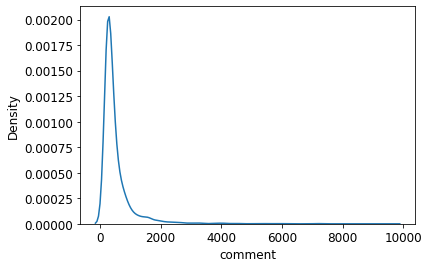

In [30]:
sns.kdeplot(data[data.comment.str.len() >= 200].comment.str.len())

In [3]:
data = data[data.comment.str.len() >= 50]
data.groupby("username")["comment"].count()

username
9-Cortes            861
AgnaldoTeExplode    644
BeatoSalut          684
BluePirate89        400
CariocaSatanico     915
Manada_2            666
MaxVonHabsburg      783
MidnightRider00     902
Miteiro             474
Supermunch2000      696
TheGza1             575
logatwork           648
piperman_           573
um--no              865
xanax101010         625
Name: comment, dtype: int64

/home/vinicius/.local/share/virtualenvs/reddit-in-portuguese-Kyc7Ejcc/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='comment'>

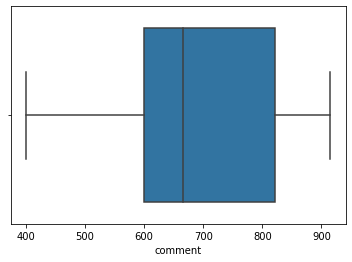

In [4]:
sns.boxplot(data.groupby("username")["comment"].count())


In [17]:
from joblib import Parallel, delayed
def process(clf, vectorizer):
    clf_str = clf.__str__()
    print(f"Running ===> {clf_str}")
    evaluation = list()
    usernames = list(np.unique(data["username"]))

    for i in range(len(usernames)):
        author1 = usernames.pop()

        for author2 in usernames:
            X_train, X_test, y_train, y_test = temporal_train_test_split(   
                data, author1, author2)

            under_sampler = RandomUnderSampler()
            X_train, y_train = under_sampler.fit_resample(X_train, y_train)

            author_clf = AuthorClassifier(clf=clf, vectorizer=vectorizer, scaler=MaxAbsScaler())
            author_clf.fit(X_train["comment"], y_train)
            y_pred = author_clf.predict(X_test["comment"])
            evaluation.append(author_clf.evaluate(y_test, y_pred))

    metrics = pd.DataFrame(evaluation)
    metrics["clf"] = [clf_str for i in range(len(metrics))]

    print(f"Finish <=== {clf_str}")
    return metrics
        
results = Parallel(n_jobs=7)(delayed(process)(clf, vectorizer) for clf, vectorizer in grid)

Running ===> LogisticRegression(penalty='l1', random_state=42, solver='liblinear')
Running ===> LinearSVC(max_iter=10000, random_state=42)
Running ===> RandomForestClassifier(random_state=42)
Running ===> MultinomialNB()
Running ===> LogisticRegression(random_state=42, solver='liblinear')
Running ===> SVC(random_state=42)
Running ===> DecisionTreeClassifier(random_state=42)
Finish <=== LogisticRegression(random_state=42, solver='liblinear')
Running ===> AdaBoostClassifier(random_state=42)
Finish <=== LinearSVC(max_iter=10000, random_state=42)
Running ===> GradientBoostingClassifier(random_state=42)
Finish <=== MultinomialNB()
Running ===> StackingClassifier(estimators=[('svm',
                                LinearSVC(max_iter=10000, random_state=42)),
                               ('lr_l1',
                                LogisticRegression(penalty='l1',
                                                   random_state=42,
                                                   solver='libl

In [18]:
metrics_df = pd.concat(results)
metrics_df.clf.unique()

array(['MultinomialNB()',
       "LogisticRegression(penalty='l1', random_state=42, solver='liblinear')",
       "LogisticRegression(random_state=42, solver='liblinear')",
       'LinearSVC(max_iter=10000, random_state=42)',
       'SVC(random_state=42)', 'DecisionTreeClassifier(random_state=42)',
       'RandomForestClassifier(random_state=42)',
       'AdaBoostClassifier(random_state=42)',
       'GradientBoostingClassifier(random_state=42)',
       "StackingClassifier(estimators=[('svm',\n                                LinearSVC(max_iter=10000, random_state=42)),\n                               ('lr_l1',\n                                LogisticRegression(penalty='l1',\n                                                   random_state=42,\n                                                   solver='liblinear'),\n                                'rf',\n                                RandomForestClassifier(random_state=42))],\n                   final_estimator=LogisticRegression(random

In [21]:
keys = metrics_df.clf.unique()
values = ['Naive Bayes Multinomial',
        'Regressão Logística (L1)',
        'Regressão Logística (L2)',
        'SVM (kernel linear)',
        'SVM (kernel rbf)',
        'Árvore de Decisão',
        'Random Forest',
        'AdaBoost',
        'Gradient boosting',
        'Stacking']

dict_clf = dict(zip(keys, values))

In [22]:
metrics_df["clf"] = metrics_df["clf"].map(dict_clf)

In [23]:
metrics_df.to_csv("../../results/otimal_results_min_size_50.csv")

In [25]:
keys = ['Naive Bayes Multinomial',
        'Regressão Logística (L1)',
        'Regressão Logística (L2)',
        'SVM (kernel linear)',
        'SVM (kernel rbf)',
        'Árvore de Decisão',
        'Random Forest',
        'AdaBoost',
        'Gradient boosting',
        'Stacking']

values = ['Multinomial Naive Bayes',
        'Logistic Regression (L1)',
        'Logistic Regression (L2)',
        'SVM (linear kernel)',
        'SVM (rbf kernel)',
        'Decision Tree',
        'Random Forest',
        'AdaBoost',
        'Gradient boosting',
        'Stacking']

dict_clf = dict(zip(keys, values))

In [26]:
metrics_df["clf"] = metrics_df["clf"].map(dict_clf)

Text(0, 0.5, 'Accuracy')

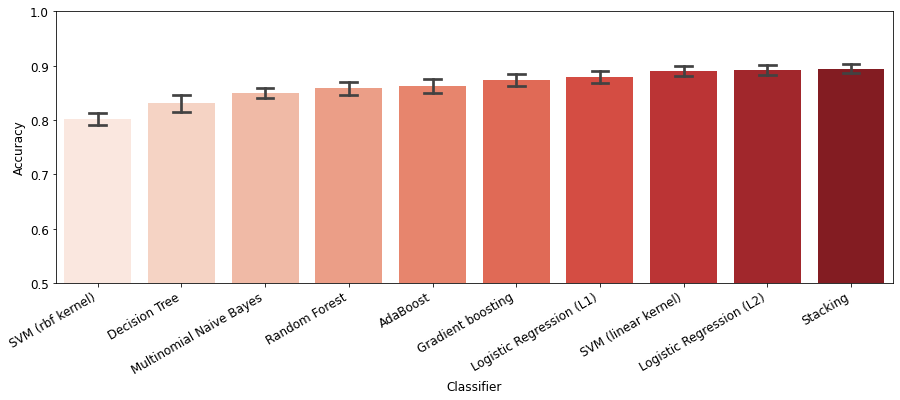

In [27]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='accuracy', data=metrics_df, estimator=np.mean, ci=95, capsize=.2,palette="Reds", order=metrics_df.groupby("clf").mean()["accuracy"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

Text(0, 0.5, 'F1-score')

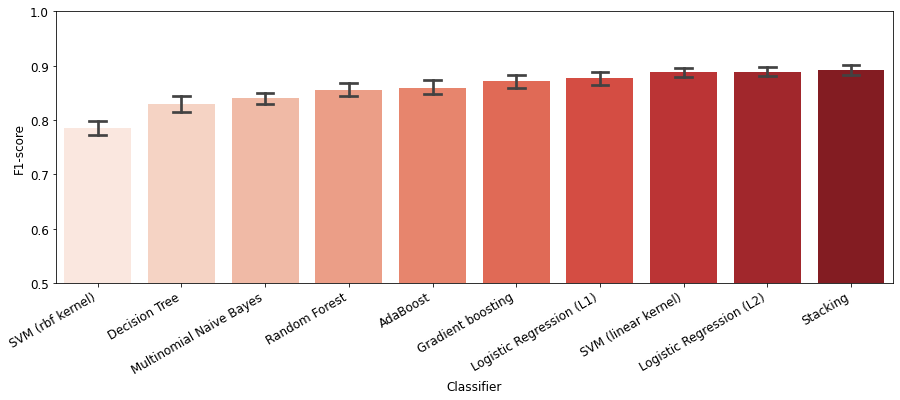

In [28]:
plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='f1_macro', data=metrics_df, estimator=np.mean, ci=95, capsize=.2,palette="Reds", order=metrics_df.groupby("clf").mean()["f1_macro"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('F1-score')

Text(0, 0.5, 'AUC')

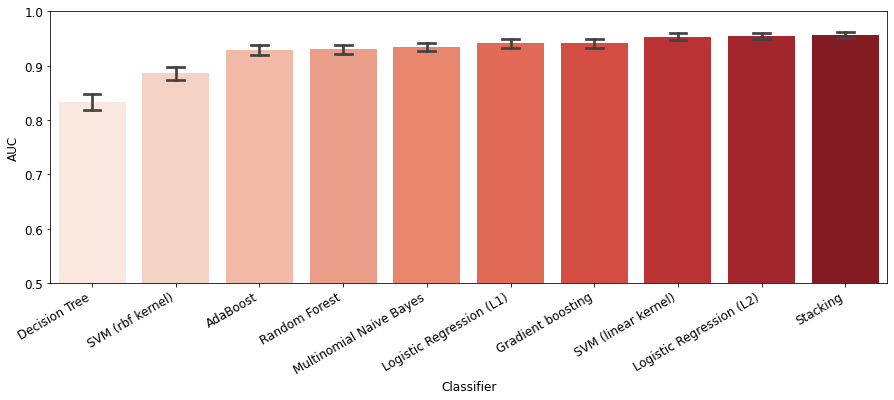

In [29]:
plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.barplot(x='clf', y='auc_score', data=metrics_df, estimator=np.mean, ci=95, capsize=.2, palette="Reds", order=metrics_df.groupby("clf").mean()["auc_score"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('AUC')

Text(0, 0.5, 'Accuracy')

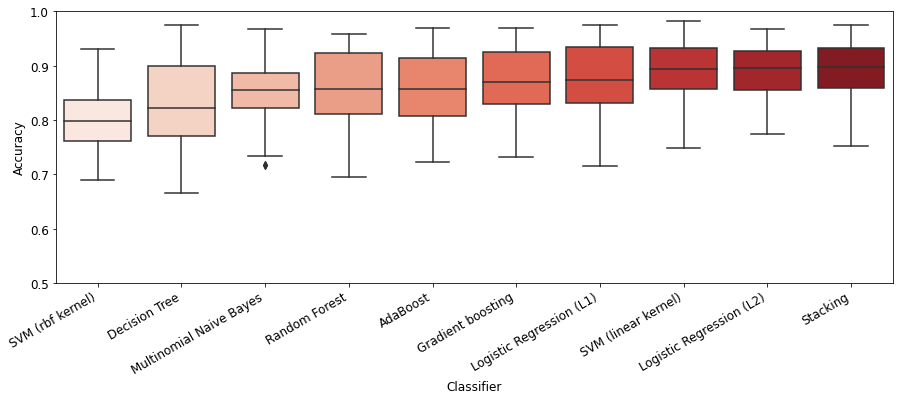

In [30]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.boxplot(x='clf', y='accuracy', data=metrics_df, palette="Reds", order=metrics_df.groupby("clf").median()["accuracy"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

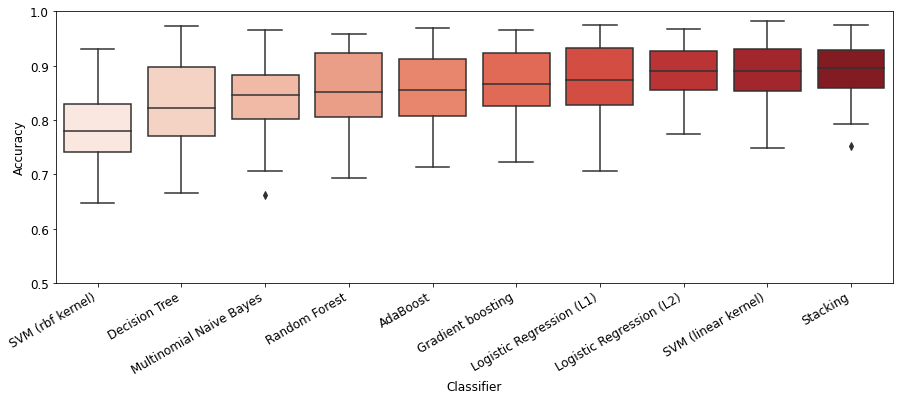

In [31]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.boxplot(x='clf', y='f1_macro', data=metrics_df, palette="Reds", order=metrics_df.groupby("clf").median()["f1_macro"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

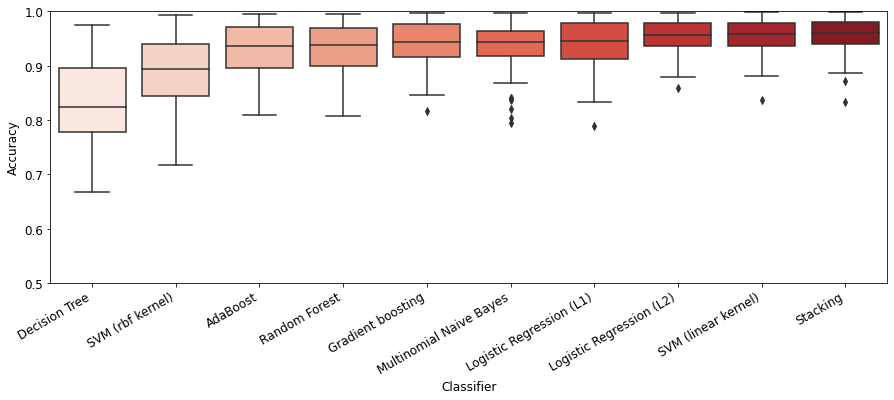

In [32]:
font = {'size': 12}

matplotlib.rc('font', **font)

plt.figure(figsize=(15,5))
plt.ylim(0.5, 1)
plt.xticks(rotation=30, ha='right')
sns.boxplot(x='clf', y='auc_score', data=metrics_df, palette="Reds", order=metrics_df.groupby("clf").median()["auc_score"].sort_values().reset_index()["clf"])
plt.xlabel('Classifier')
plt.ylabel('Accuracy')

In [39]:
metrics_df[metrics_df["auc_score"] == metrics_df["auc_score"].max()]

,author1,author2,precision_author1,recall_author1,f1_score_author1,precision_author2,recall_author2,f1_score_author2,precision_weighted,precision_micro,precision_macro,recall_weighted,recall_micro,recall_macro,f1_weighted,f1_micro,f1_macro,auc_score,accuracy,clf
6,MaxVonHabsburg,xanax101010,0.9845,0.9694,0.9769,0.9625,0.9809,0.9716,0.9747,0.9745,0.9735,0.9745,0.9745,0.9751,0.9745,0.9745,0.9742,0.9989,0.9745,Stacking
